# Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import imghdr
import os
import splitfolders
import tensorflow as tf
import shutil
import random
from skimage.color import rgb2gray
# from torchvision.datasets import ImageFolder

import keras
import PIL.Image as Image
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import graphviz
import pydot
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from keras.layers import Activation
from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
import logging
tf.get_logger().setLevel(logging.ERROR)

## Transfer Learning for Image Classification
It is highly recommended that you complete this project using Keras2 and Python. 
#### (a) In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders. 
#### (b) Data Exploration and Pre-processing
i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.
ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.
iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [3]:
dir_path = '../Data/images'

for image_class in os.listdir(dir_path):
    class_path = os.path.join(dir_path, image_class)
    for img in os.listdir(class_path):
        image_path = os.path.join(dir_path, image_class, img)

In [4]:
# Split data into train, val test data

dir_path = '../Data/images' # data root path
image_class_list = os.listdir(dir_path)
print(image_class_list)

['005.Crested_Auklet', '015.Lazuli_Bunting', '156.White_eyed_Vireo', '081.Pied_Kingfisher', '135.Bank_Swallow', '086.Pacific_Loon', '067.Anna_Hummingbird', '076.Dark_eyed_Junco', '149.Brown_Thrasher', '127.Savannah_Sparrow', '041.Scissor_tailed_Flycatcher', '141.Artic_Tern', '082.Ringed_Kingfisher', '099.Ovenbird', '013.Bobolink', '104.American_Pipit', '023.Brandt_Cormorant', '168.Kentucky_Warbler', '072.Pomarine_Jaeger', '040.Olive_sided_Flycatcher']


In [5]:
dir_path = '../Data/images' # data root path
count = 0
for image_class in image_class_list:
    os.makedirs(dir_path +'_train/' + image_class)
    os.makedirs(dir_path +'_val/' + image_class)
    os.makedirs(dir_path +'_test/' + image_class)
    

In [6]:
all_sources = []

all_train_files = []
all_val_files = []
all_test_files = []

all_train_labels = []

for i, image_class in enumerate(image_class_list):

    source = dir_path + '/' + image_class
    all_sources.append(source)
    
    all_file_names = os.listdir(source)
    
    np.random.shuffle(all_file_names)
    val_ratio = 0.15
    test_ratio = 0.15
    
    train_file_names, val_file_names, test_file_names = np.split(np.array(all_file_names), \
                                                                 [int(len(all_file_names)* (1 - (test_ratio+val_ratio))), \
                                                                  int(len(all_file_names)* (1 - test_ratio))])

    train_file_names = [source + '/' + name for name in train_file_names.tolist()]
    val_file_names = [source + '/' + name for name in val_file_names.tolist()]
    test_file_names = [source + '/' + name for name in test_file_names.tolist()]
    
    all_train_files.extend(train_file_names)
    
    all_val_files.extend(val_file_names)
    
    all_test_files.extend(test_file_names)

    # Copy-pasting images
    for name in train_file_names:
        shutil.copy(name, dir_path +'_train/' + image_class)
        all_train_labels.append(i)
    for name in val_file_names:
        shutil.copy(name, dir_path +'_val/' + image_class)
    for name in test_file_names:
        shutil.copy(name, dir_path +'_test/' + image_class)

        

In [7]:
train_path = '../Data/images_train'
val_path = '../Data/images_val'
test_path = '../Data/images_test'

In [8]:
# Generate train, validation, and test Dataset
train_data = tf.keras.utils.image_dataset_from_directory(train_path, image_size=(224, 224), label_mode='categorical') 
val_data = tf.keras.utils.image_dataset_from_directory(val_path, image_size=(224, 224), label_mode='categorical') 
test_data = tf.keras.utils.image_dataset_from_directory(test_path, image_size=(224, 224), label_mode='categorical') 
# default batch size: 32
# default image size = (256, 256)

Found 820 files belonging to 20 classes.
Found 178 files belonging to 20 classes.
Found 178 files belonging to 20 classes.


2022-12-12 06:31:15.713890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>

In [10]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>

In [11]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>

#### (c) Transfer Learning
i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

v. Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem.

## Efficient Net B0

In [32]:
# Using image data augmentation
# When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity.
# Applying random transformations to the training images, such as random horizontal flipping or small random rotations. 
# This helps expose the model to different aspects of the training data while slowing down overfitting.
img_augmentation = keras.Sequential(
    [
        keras.layers.RandomCrop(224,224),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(height_factor=(-0.1,0.1)),
        keras.layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
        keras.layers.RandomRotation(factor=(-0.1, 0.1)),
        keras.layers.RandomContrast(factor=0.1)
    ],
    name="img_augmentation",
)

inputs = layers.Input(shape=(224, 224, 3))
# x = img_augmentation(inputs)
eff_model = EfficientNetB0(weights='imagenet', include_top=True)
for layer in eff_model.layers[:-1]:
    eff_model.trainable = False 
eff_model.layers.pop() 
# keras.utils.plot_model(eff_model, show_shapes=True)

# e_model = Sequential([inputs, \
#                       img_augmentation, \
#                       eff_model, \
#                       layers.Dense(20, activation='relu', name='output'), \
#                      ],
#                      name='efficient_first_model'
#                     )

e_model = Sequential(name='efficient_first_model')
e_model.add(inputs)
e_model.add(img_augmentation)
e_model.add(eff_model)
e_model.add(layers.Dense(20, activation='relu', name='output'))

print('2.')
print(e_model.summary())
print(e_model.output_shape)

e_model.add(Dropout(0.20))
e_model.add(tf.keras.layers.BatchNormalization())
e_model.add(tf.keras.layers.Softmax())
# e_model.build()

print('3.')
print(e_model.summary())
print(e_model.output_shape)


2.
Model: "efficient_first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 output (Dense)              (None, 20)                20020     
                                                                 
Total params: 5,350,591
Trainable params: 20,020
Non-trainable params: 5,330,571
_________________________________________________________________
None
(None, 20)
3.
Model: "efficient_first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 224, 2

In [33]:
# learning_rate=0.1
opt = keras.optimizers.Adam()
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=15, callbacks=[early_stop])
# callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]

'''
print(train_data)
print(type(train_data))

for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print('>>>')
    print(print(label[0]))
    print(label[1])
'''
# fit the model
e_history = e_model.fit(
    train_data,
    epochs=100,
    callbacks=[early_stop],
    batch_size=5,
    validation_data=val_data,
)


Epoch 1/100
26/26 [==============================] - 60s 2s/step - loss: 3.0060 - accuracy: 0.0939 - val_loss: 2.9938 - val_accuracy: 0.1180
Epoch 2/100
26/26 [==============================] - 44s 2s/step - loss: 2.9092 - accuracy: 0.1512 - val_loss: 2.9891 - val_accuracy: 0.1629
Epoch 3/100
26/26 [==============================] - 54s 2s/step - loss: 2.8305 - accuracy: 0.1854 - val_loss: 2.9832 - val_accuracy: 0.2135
Epoch 4/100
26/26 [==============================] - 46s 2s/step - loss: 2.7585 - accuracy: 0.2073 - val_loss: 2.9759 - val_accuracy: 0.2472
Epoch 5/100
26/26 [==============================] - 44s 2s/step - loss: 2.6913 - accuracy: 0.2610 - val_loss: 2.9670 - val_accuracy: 0.2865
Epoch 6/100
26/26 [==============================] - 43s 2s/step - loss: 2.6659 - accuracy: 0.2537 - val_loss: 2.9548 - val_accuracy: 0.3539
Epoch 7/100
26/26 [==============================] - 43s 2s/step - loss: 2.6026 - accuracy: 0.2915 - val_loss: 2.9384 - val_accuracy: 0.3371
Epoch 8/100
2

Epoch 59/100
26/26 [==============================] - 42s 2s/step - loss: 1.7206 - accuracy: 0.5585 - val_loss: 1.4413 - val_accuracy: 0.5899
Epoch 60/100
26/26 [==============================] - 41s 2s/step - loss: 1.6950 - accuracy: 0.5415 - val_loss: 1.4253 - val_accuracy: 0.5843
Epoch 61/100
26/26 [==============================] - 41s 2s/step - loss: 1.6860 - accuracy: 0.5427 - val_loss: 1.4327 - val_accuracy: 0.5955
Epoch 62/100
26/26 [==============================] - 44s 2s/step - loss: 1.6437 - accuracy: 0.5683 - val_loss: 1.4339 - val_accuracy: 0.5955
Epoch 63/100
26/26 [==============================] - 46s 2s/step - loss: 1.6820 - accuracy: 0.5549 - val_loss: 1.4125 - val_accuracy: 0.6067
Epoch 64/100
26/26 [==============================] - 44s 2s/step - loss: 1.6443 - accuracy: 0.5707 - val_loss: 1.4076 - val_accuracy: 0.5955
Epoch 65/100
26/26 [==============================] - 45s 2s/step - loss: 1.6189 - accuracy: 0.5683 - val_loss: 1.3921 - val_accuracy: 0.6011
Epoch 

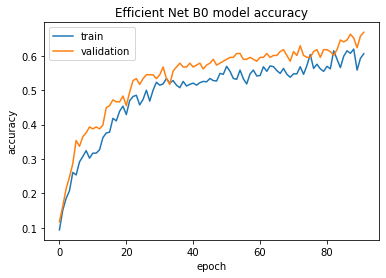

In [34]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Efficient Net B0 model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(e_history)

In [30]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.metrics import f1_score
import sklearn.metrics
from sklearn.metrics import recall_score

y = []
y_label = []
for img, label in test_data:
    e_predictions = e_model.predict(img)
    # y.append(e_predictions)
    for i in range(len(label)):
        
        cla = np.argmax(e_predictions[i])
        class_list = [0] * 20
        class_list[cla] = 1
        y.append(class_list)

        y_label.append(label[i])

# y_train_prediction = clf_lr.predict(pruned_features_df)
cm = multilabel_confusion_matrix(y_true=y_label, y_pred=y)
# print(cm)



1/1 [==============================] - 4s 4s/step


In [31]:
import math

per_class_precision = [0] * 20
per_class_recall = [0] * 20
per_class_f_score = [0] * 20

for idx in range(20):
    # print(cm[idx])
    tn, fp, fn, tp = cm[idx].ravel()   
    precision = (tp) / (tp+fp)
    TPR = tp / (tp + fn) 
    per_class_precision[idx] = precision
    per_class_recall[idx] = (tp) / (tp+fn)
    
    # calculate: F score
    f_score = 2 * (precision * TPR) / (precision + TPR)
    per_class_f_score[idx] = f_score

print('Precision:')
for i in range(len(per_class_precision)):
    if math.isnan(per_class_precision[i]):
        per_class_precision[i] = 'NAN'
    print('Class', i+1, ': ', per_class_precision[i])
# print(per_class_precision)

print()
print('Recall:')
for i in range(len(per_class_recall)):
    print('Class', i+1, ': ', per_class_recall[i])
# print(per_class_recall)

print()
print('F1 score:')
for i in range(len(per_class_recall)):
    print('Class', i+1, ': ', per_class_recall[i])




Precision:
Class 1 :  NAN
Class 2 :  0.625
Class 3 :  NAN
Class 4 :  0.47058823529411764
Class 5 :  NAN
Class 6 :  0.8888888888888888
Class 7 :  1.0
Class 8 :  0.45
Class 9 :  0.25
Class 10 :  NAN
Class 11 :  NAN
Class 12 :  NAN
Class 13 :  1.0
Class 14 :  NAN
Class 15 :  0.2916666666666667
Class 16 :  0.45454545454545453
Class 17 :  0.8888888888888888
Class 18 :  0.625
Class 19 :  0.7777777777777778
Class 20 :  0.8181818181818182

Recall:
Class 1 :  0.0
Class 2 :  0.5555555555555556
Class 3 :  0.0
Class 4 :  0.8888888888888888
Class 5 :  0.0
Class 6 :  0.8888888888888888
Class 7 :  1.0
Class 8 :  1.0
Class 9 :  1.0
Class 10 :  0.0
Class 11 :  0.0
Class 12 :  0.0
Class 13 :  0.7777777777777778
Class 14 :  0.0
Class 15 :  0.7777777777777778
Class 16 :  0.5555555555555556
Class 17 :  0.8888888888888888
Class 18 :  0.5555555555555556
Class 19 :  0.7777777777777778
Class 20 :  1.0

F1 score:
Class 1 :  0.0
Class 2 :  0.5555555555555556
Class 3 :  0.0
Class 4 :  0.8888888888888888
Class 5 :

/var/folders/w4/4m2552cs59qb6pc9x_6d0_c40000gp/T/ipykernel_51477/541584085.py:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = (tp) / (tp+fp)


## VGG16

In [19]:
img_augmentation = keras.Sequential(
    [
        keras.layers.RandomCrop(224,224),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomZoom(height_factor=(-0.1,0.1)),
        keras.layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
        keras.layers.RandomRotation(factor=(-0.1, 0.1)),
        keras.layers.RandomContrast(factor=0.1)
    ],
    name="img_augmentation",
)

inputs = layers.Input(shape=(224, 224, 3))
# x = img_augmentation(inputs)
# vgg_model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
vgg_model = VGG16(weights="imagenet", include_top=False)

for layer in vgg_model.layers[:-1]:
    vgg_model.trainable = False 
vgg_model.layers.pop() 
# keras.utils.plot_model(vgg_model, show_shapes=True)

# e_model = Sequential([inputs, \
#                       img_augmentation, \
#                       eff_model, \
#                       layers.Dense(20, activation='relu', name='output'), \
#                      ],
#                      name='efficient_first_model'
#                     )

v_model = Sequential(name='vgg16_first_model')
v_model.add(inputs)
v_model.add(img_augmentation)
v_model.add(eff_model)
v_model.add(layers.Dense(20, activation='relu', name='output'))


v_model.add(Dropout(0.20))
v_model.add(tf.keras.layers.BatchNormalization())
v_model.add(tf.keras.layers.Softmax())
# e_model.build()


In [24]:
# opt = keras.optimizers.Adam(learning_rate=1)
opt = keras.optimizers.Adam()
v_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=15, callbacks=[early_stop])
# callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]

'''
print(train_data)
print(type(train_data))

for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print('>>>')
    print(print(label[0]))
    print(label[1])
'''
# fit the model
v_history = v_model.fit(
    train_data,
    epochs=100,
    callbacks=[early_stop],
    batch_size=5,
    validation_data=val_data,
)


Epoch 1/100
26/26 [==============================] - 63s 2s/step - loss: 2.7198 - accuracy: 0.2573 - val_loss: 2.9670 - val_accuracy: 0.3034
Epoch 2/100
26/26 [==============================] - 45s 2s/step - loss: 2.6198 - accuracy: 0.2927 - val_loss: 2.9531 - val_accuracy: 0.3652
Epoch 3/100
26/26 [==============================] - 43s 2s/step - loss: 2.5532 - accuracy: 0.3049 - val_loss: 2.9360 - val_accuracy: 0.4157
Epoch 4/100
26/26 [==============================] - 44s 2s/step - loss: 2.4479 - accuracy: 0.3622 - val_loss: 2.9152 - val_accuracy: 0.4663
Epoch 5/100
26/26 [==============================] - 47s 2s/step - loss: 2.4066 - accuracy: 0.3902 - val_loss: 2.8936 - val_accuracy: 0.4607
Epoch 6/100
26/26 [==============================] - 45s 2s/step - loss: 2.3663 - accuracy: 0.3902 - val_loss: 2.8702 - val_accuracy: 0.5112
Epoch 7/100
26/26 [==============================] - 41s 2s/step - loss: 2.3229 - accuracy: 0.3988 - val_loss: 2.8434 - val_accuracy: 0.5056
Epoch 8/100
2

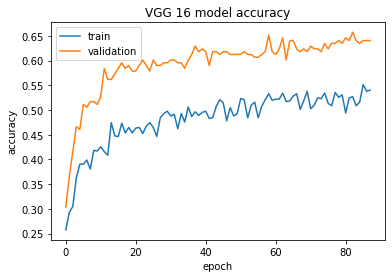

In [25]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("VGG 16 model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(v_history)

In [26]:
y = []
y_label = []
for img, label in test_data:
    v_predictions = v_model.predict(img)
    # y.append(e_predictions)
    for i in range(len(label)):
        
        cla = np.argmax(v_predictions[i])
        class_list = [0] * 20
        class_list[cla] = 1
        y.append(class_list)

        y_label.append(label[i])

# y_train_prediction = clf_lr.predict(pruned_features_df)
cm = multilabel_confusion_matrix(y_true=y_label, y_pred=y)
# print(cm)


1/1 [==============================] - 2s 2s/step


In [27]:
per_class_precision = [0] * 20
per_class_recall = [0] * 20
per_class_f_score = [0] * 20

for idx in range(20):
    # print(cm[idx])
    tn, fp, fn, tp = cm[idx].ravel()   
    precision = (tp) / (tp+fp)
    TPR = tp / (tp + fn) 
    per_class_precision[idx] = precision
    per_class_recall[idx] = (tp) / (tp+fn)
    
    # calculate: F score
    f_score = 2 * (precision * TPR) / (precision + TPR)
    per_class_f_score[idx] = f_score

print('Precision:')
for i in range(len(per_class_precision)):
    if math.isnan(per_class_precision[i]):
        per_class_precision[i] = 'NAN'
    print('Class', i+1, ': ', per_class_precision[i])
# print(per_class_precision)

print()
print('Recall:')
for i in range(len(per_class_recall)):
    print('Class', i+1, ': ', per_class_recall[i])
# print(per_class_recall)

print()
print('F1 score:')
for i in range(len(per_class_recall)):
    print('Class', i+1, ': ', per_class_recall[i])




Precision:
Class 1 :  0.7777777777777778
Class 2 :  0.7142857142857143
Class 3 :  1.0
Class 4 :  0.6666666666666666
Class 5 :  0.2222222222222222
Class 6 :  0.8181818181818182
Class 7 :  1.0
Class 8 :  0.6
Class 9 :  NAN
Class 10 :  1.0
Class 11 :  1.0
Class 12 :  0.8
Class 13 :  0.7272727272727273
Class 14 :  0.5
Class 15 :  NAN
Class 16 :  NAN
Class 17 :  NAN
Class 18 :  1.0
Class 19 :  NAN
Class 20 :  0.75

Recall:
Class 1 :  1.0
Class 2 :  0.5555555555555556
Class 3 :  1.0
Class 4 :  0.8888888888888888
Class 5 :  0.8888888888888888
Class 6 :  1.0
Class 7 :  1.0
Class 8 :  1.0
Class 9 :  0.0
Class 10 :  0.7777777777777778
Class 11 :  0.7777777777777778
Class 12 :  0.8888888888888888
Class 13 :  0.8888888888888888
Class 14 :  0.8888888888888888
Class 15 :  0.0
Class 16 :  0.0
Class 17 :  0.0
Class 18 :  0.7777777777777778
Class 19 :  0.0
Class 20 :  1.0

F1 score:
Class 1 :  1.0
Class 2 :  0.5555555555555556
Class 3 :  1.0
Class 4 :  0.8888888888888888
Class 5 :  0.8888888888888888
C

/var/folders/w4/4m2552cs59qb6pc9x_6d0_c40000gp/T/ipykernel_51477/2809727637.py:8: RuntimeWarning: invalid value encountered in long_scalars
  precision = (tp) / (tp+fp)
